In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
data_path = '../evaluation'

# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [3]:
import argparse
import os
import sys
import torch
from tqdm import tqdm
import cv2
import numpy as np
sys.path.append('../detectron2')
sys.path.append('../')

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, default_setup, launch
from detectron2.evaluation import COCOEvaluator, verify_results

from utils import mkdir, save_features
from extract_utils import get_image_blob
from models.bua import add_bottom_up_attention_config
from models.bua.layers.nms import nms

In [4]:
config_file = '../configs/bua-caffe/extract-bua-caffe-r101.yaml'

cfg = get_cfg()
add_bottom_up_attention_config(cfg, True)
cfg.merge_from_file(config_file)
cfg.freeze()

Config '../configs/bua-caffe/extract-bua-caffe-r101.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [5]:
MIN_BOXES = 10
MAX_BOXES = 50
CONF_THRESH = 0.4

model = DefaultTrainer.build_model(cfg)
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
    '../'+cfg.MODEL.WEIGHTS, resume=True
)
model.eval()

ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
Some model parameters or buffers are not found in the checkpoint:
backbone.res4.0.conv1.norm.num_batches_tracked
backbone.res4.0.conv2.norm.num_batches_tracked
backbone.res4.0.conv3.norm.num_batches_tracked
backbone.res4.0.shortcut.norm.num_batches_tracked
backbone.res4.1.conv1.norm.num_batches_tracked
backbone.res4.1.conv2.norm.num_batches_tracked
backbone.res4.1.conv3.norm.num_batches_tracked
backbone.res4.10.conv1.norm.num_batches_tracked
backbone.res4.10.conv2.norm.num_batches_tracked
backbone.res4.10.conv3.norm.num_batches_tracked
backbone.res4.11.conv1.norm.num_batches_tracked
backbone.res4.11.conv2.norm.num_batches_tracked
backbone.res4.11.conv3.norm.num_batches_tracked
backbone.res4.12.conv1.norm.num_bat

GeneralizedBUARCNN(
  (backbone): ResNet(
    (stem): BUABasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): Bottleneck

/nethome/sramshetty3/anaconda3/envs/objects/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352430114/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


boxes=22


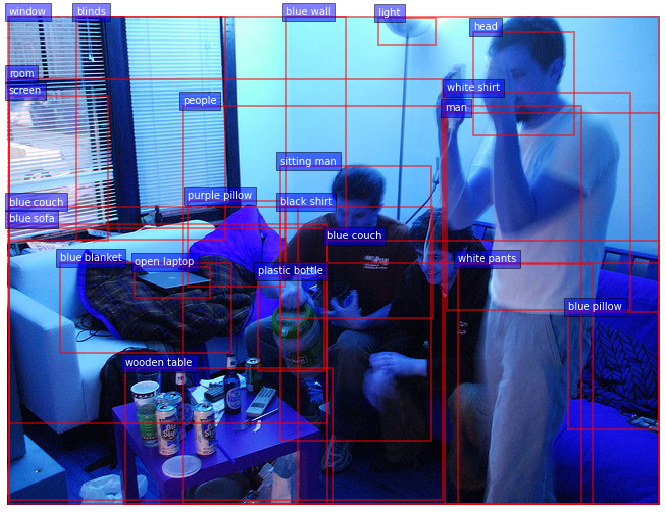

In [6]:
im_file = <Image PATH>
im = cv2.imread(im_file)

# im = Image.open(BytesIO(base64.urlsafe_b64decode(metadata.iloc[0]['image']))).convert('RGB')
im = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)

dataset_dict = get_image_blob(im, cfg.MODEL.PIXEL_MEAN)

with torch.set_grad_enabled(False):
    boxes, scores, features_pooled, attr_scores = model([dataset_dict])

dets = boxes[0].tensor.cpu() / dataset_dict['im_scale']
scores = scores[0].cpu()
feats = features_pooled[0].cpu()
attr_scores = attr_scores[0].cpu()

max_conf = torch.zeros((scores.shape[0])).to(scores.device)
for cls_ind in range(1, scores.shape[1]):
        cls_scores = scores[:, cls_ind]
        keep = nms(dets, cls_scores, 0.3)
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                    cls_scores[keep],
                                    max_conf[keep])
            
keep_boxes = torch.nonzero(max_conf >= CONF_THRESH).flatten()
if len(keep_boxes) < MIN_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MIN_BOXES]
elif len(keep_boxes) > MAX_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MAX_BOXES]

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(im)

boxes = dets[keep_boxes].numpy()
objects = np.argmax(scores[keep_boxes].numpy()[:,1:], axis=1)
attr_thresh = 0.1
attr = np.argmax(attr_scores[keep_boxes].numpy()[:,1:], axis=1)
attr_conf = np.max(attr_scores[keep_boxes].numpy()[:,1:], axis=1)

for i in range(len(keep_boxes)):
    bbox = boxes[i]
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects[i]+1]
    if attr_conf[i] > attr_thresh:
        cls = attributes[attr[i]+1] + " " + cls
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '%s' % (cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=10, color='white')
print('boxes={}'.format(len(keep_boxes)))

In [7]:
[classes[o+1] for o in objects]

['room',
 'people',
 'couch',
 'wall',
 'shirt',
 'sofa',
 'couch',
 'man',
 'window',
 'table',
 'man',
 'pants',
 'shirt',
 'light',
 'pillow',
 'blanket',
 'pillow',
 'bottle',
 'laptop',
 'blinds',
 'head',
 'screen']

In [8]:
[attributes[a+1] for a in attr]

['blue',
 'sitting',
 'blue',
 'blue',
 'white',
 'blue',
 'blue',
 'sitting',
 'blue',
 'wooden',
 'playing',
 'white',
 'black',
 'white',
 'purple',
 'blue',
 'blue',
 'plastic',
 'open',
 'blue',
 'black',
 'white']

### Create Modified Captions (COCO)

In [9]:
with open('captions_val2017.json') as f:
    metadata = json.load(f)
    images = metadata['images']
    captions = metadata['annotations']

In [10]:
images_df = pd.DataFrame(images)
captions_df = pd.DataFrame(captions)

In [23]:
print(images_df.shape)
images_df.head()

(5000, 8)


,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,4,000000397133.jpg,http://images.cocodataset.org/val2017/00000039...,427,640,2013-11-14 17:02:52,http://farm7.staticflickr.com/6116/6255196340_...,397133
1,1,000000037777.jpg,http://images.cocodataset.org/val2017/00000003...,230,352,2013-11-14 20:55:31,http://farm9.staticflickr.com/8429/7839199426_...,37777
2,4,000000252219.jpg,http://images.cocodataset.org/val2017/00000025...,428,640,2013-11-14 22:32:02,http://farm4.staticflickr.com/3446/3232237447_...,252219
3,1,000000087038.jpg,http://images.cocodataset.org/val2017/00000008...,480,640,2013-11-14 23:11:37,http://farm8.staticflickr.com/7355/8825114508_...,87038
4,6,000000174482.jpg,http://images.cocodataset.org/val2017/00000017...,388,640,2013-11-14 23:16:55,http://farm8.staticflickr.com/7020/6478877255_...,174482


In [17]:
print(captions_df.shape)
captions_df.sample(5)

(25014, 3)


,image_id,id,caption
6432,5992,461058,A herd of sheep standing on top of a green gra...
10195,98839,436501,A cat that is looking at a television screen.
983,481404,197100,The inside view of a large decorated church.
9620,286458,305797,A briefcase sitting on top of a bed with lots ...
18077,254368,416791,Adult man wearing bathrobe in bed while eating...


In [36]:
%%time
caption_info = pd.DataFrame(columns = ['image_id','file', 'url', 'objects','attributes','original'])

image_dir = '../images/val2017/'

for file in tqdm(images_df['file_name']):
    # print(os.path.exists(image_dir + file))
    im = cv2.imread(image_dir + file)
    dataset_dict = get_image_blob(im, cfg.MODEL.PIXEL_MEAN)

    with torch.set_grad_enabled(False):
        boxes, scores, features_pooled, attr_scores = model([dataset_dict])

    dets = boxes[0].tensor.cpu() / dataset_dict['im_scale']
    scores = scores[0].cpu()
    feats = features_pooled[0].cpu()
    attr_scores = attr_scores[0].cpu()

    max_conf = torch.zeros((scores.shape[0])).to(scores.device)
    for cls_ind in range(1, scores.shape[1]):
            cls_scores = scores[:, cls_ind]
            keep = nms(dets, cls_scores, 0.3)
            max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                        cls_scores[keep],
                                        max_conf[keep])

    keep_boxes = torch.nonzero(max_conf >= CONF_THRESH).flatten()
    if len(keep_boxes) < MIN_BOXES:
        keep_boxes = torch.argsort(max_conf, descending=True)[:MIN_BOXES]
    elif len(keep_boxes) > MAX_BOXES:
        keep_boxes = torch.argsort(max_conf, descending=True)[:MAX_BOXES]

    objects = np.argmax(scores[keep_boxes].numpy()[:,1:], axis=1)
    attr_thresh = 0.1
    attr = np.argmax(attr_scores[keep_boxes].numpy()[:,1:], axis=1)
    attr_conf = np.max(attr_scores[keep_boxes].numpy()[:,1:], axis=1)
    
    class_objects = [classes[o+1] for o in objects]
    object_attributes = [attributes[a+1] for i, a in enumerate(attr)] # Removed attribute confidence threshold
    
    image_id = images_df[images_df['file_name'] == file]['id']
    image_url = images_df[images_df['file_name'] == file]['coco_url']
    orig_captions = captions_df[captions_df['image_id'] == int(image_id)]['caption']
    
    for cap in orig_captions:
        caption_info = caption_info.append({'image_id': image_id, 'file': file, "url": image_url, 'objects': class_objects, 'attributes': object_attributes, 'original': cap}, ignore_index=True)        

caption_info.sample(5)

100%|███████████████████████████████████████████████████████████████████| 5000/5000 [47:52<00:00,  1.74it/s]

CPU times: user 6h 52min 35s, sys: 18min 13s, total: 7h 10min 49s
Wall time: 47min 52s


,image_id,file,url,objects,attributes,original
24765,"4950 322610 Name: id, dtype: int64",000000322610.jpg,4950 http://images.cocodataset.org/val2017/...,"[woman, window, woman, sign, bag, purse, bag, ...","[walking, black, walking, black, plastic, blac...",A woman leaning against a store front with an ...
1458,"291 152740 Name: id, dtype: int64",000000152740.jpg,291 http://images.cocodataset.org/val2017/0...,"[field, field, cow, cow, cow, cow, cow, cow, a...","[green, brown, black, black, grazing, black, b...",A herd of cows grazing in a grassy field.
21950,"4387 231125 Name: id, dtype: int64",000000231125.jpg,4387 http://images.cocodataset.org/val2017/...,"[apron, bowl, window, donut, bag, apron, shirt...","[orange, metal, large, round, orange, orange, ...",A person putting doughnuts into a bag in a shop.
7153,"1429 274219 Name: id, dtype: int64",000000274219.jpg,1429 http://images.cocodataset.org/val2017/...,"[man, mustache, face, nose, collar, eye, eye, ...","[old, gray, short, small, white, dark, dark, b...",A man wearing a jacket and a bow tie.
13881,"2774 462031 Name: id, dtype: int64",000000462031.jpg,2774 http://images.cocodataset.org/val2017/...,"[player, sky, racket, helmet, pants, jersey, u...","[baseball, dark, white, white, white, striped,...",A black and white photo of a man in a baseball...


In [37]:
caption_info.shape

(25014, 6)

In [38]:
caption_info.to_csv('../preprocesed_data/coco_objs_attrs_captions.csv')

### Create Properties for SNLI-VE

In [9]:
from io import BytesIO
import base64
from PIL import Image

In [10]:
metadata = pd.read_csv("snli_ve_test.tsv", sep='\t', header=None)
metadata.columns = ["file", "id", "image", "hypothesis", "caption", "label"]
print(metadata.shape)
metadata.head()

(17901, 6)


,file,id,image,hypothesis,caption,label
0,1138784872.jpg#1r1c,1138784872,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,the kid has a blue one piece,the child in the green one piece suit is walki...,contradiction
1,1138784872.jpg#4r1n,1138784872,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,a small girl walks down the side of the road.,a small child walks down a sidewalk.,neutral
2,1138784872.jpg#4r1c,1138784872,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,a man is running indoors.,a small child walks down a sidewalk.,contradiction
3,1138784872.jpg#4r1e,1138784872,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,a toddler skips down the sidewalk.,a small child walks down a sidewalk.,entailment
4,1138784872.jpg#3r1e,1138784872,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,the girl is walking.,a girl in green walks down a city street.,entailment


In [12]:
snli_ve_caption_info = pd.DataFrame(columns = ['label','file','objects','attributes','original'])

prev_file = None
class_objects = None
object_attributes = None
for label, file, orig_caption, hyp in tqdm(zip(metadata['label'], metadata['image'], metadata['caption'], metadata['hypothesis']), total=len(metadata['image'])):
#     print(label, file, orig_caption)
    
    if file != prev_file:
        prev_file = file
        im = Image.open(BytesIO(base64.urlsafe_b64decode(file))).convert('RGB')
        im = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
        dataset_dict = get_image_blob(im, cfg.MODEL.PIXEL_MEAN)

        with torch.set_grad_enabled(False):
            boxes, scores, features_pooled, attr_scores = model([dataset_dict])

        dets = boxes[0].tensor.cpu() / dataset_dict['im_scale']
        scores = scores[0].cpu()
        feats = features_pooled[0].cpu()
        attr_scores = attr_scores[0].cpu()

        max_conf = torch.zeros((scores.shape[0])).to(scores.device)
        for cls_ind in range(1, scores.shape[1]):
                cls_scores = scores[:, cls_ind]
                keep = nms(dets, cls_scores, 0.3)
                max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                            cls_scores[keep],
                                            max_conf[keep])

        keep_boxes = torch.nonzero(max_conf >= CONF_THRESH).flatten()
        if len(keep_boxes) < MIN_BOXES:
            keep_boxes = torch.argsort(max_conf, descending=True)[:MIN_BOXES]
        elif len(keep_boxes) > MAX_BOXES:
            keep_boxes = torch.argsort(max_conf, descending=True)[:MAX_BOXES]

        objects = np.argmax(scores[keep_boxes].numpy()[:,1:], axis=1)
        attr_thresh = 0.1
        attr = np.argmax(attr_scores[keep_boxes].numpy()[:,1:], axis=1)
        attr_conf = np.max(attr_scores[keep_boxes].numpy()[:,1:], axis=1)

        class_objects = [classes[o+1] for o in objects]
        object_attributes = [attributes[a+1] for i, a in enumerate(attr)] # Removed attribute confidence threshold
    
    cap = orig_caption
    snli_ve_caption_info = snli_ve_caption_info.append({'label': label, 'file': file, 'objects': class_objects, 'attributes': object_attributes, 'original': cap, 'hypothesis': hyp}, ignore_index=True)
        

snli_ve_caption_info.sample(5)

100%|██████████████████████████████████████████████████████████████████| 17901/17901 [10:36<00:00, 28.13it/s]


,label,file,objects,attributes,original,hypothesis
17075,entailment,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[car, baby, pole, mouth, boy, eye, hair, windo...","[black, young, black, open, young, blue, blond...",a blond little boy smiling inside a car and we...,a boy is blonde
3212,neutral,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[dog, grass, grass, ball, tail, tail, leg, gra...","[brown, green, green, white, fluffy, fluffy, w...",a collie plays with a white ball in a field of...,the collie is old
2887,neutral,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[seat, bus, man, man, people, pants, shirt, ha...","[blue, white, standing, sitting, sitting, blue...",on this bus is a rather angry looking woman.,the bus was filled with angry women going to t...
15088,contradiction,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[wall, shirt, man, microphone, hand, hair, ear...","[white, green, smiling, black, black, short, p...",a man and a young boy sing together.,a band is playing.
14054,entailment,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[woman, wall, man, man, hair, glasses, hair, g...","[standing, white, standing, black, brown, blac...",a group of people working with some kind of br...,people work with machines.


In [13]:
snli_ve_caption_info.shape

(17901, 6)

In [18]:
snli_ve_caption_info.to_csv('../preprocesed_data/snli_ve_test_objects_attrs.csv')